<a href="https://colab.research.google.com/github/DiegoHuesos/Tesis_deteccion_de_ruido_en_imagenes_con_algoritmo_paralelo_de_agrupamiento/blob/master/Uso_Importancia_DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Usos e importancia del algoritmo DBSCAN

En el presente código, se emplea el algoritmo `DBSCAN` de la librería `sklearn` de diferentes formas y con diferentes conjuntos de datos para mostrar sus diferentes usos y su importancia en la academia, la investigación, la medicina, la navegación y el análisis de datos.


## Importación de librerías y declaración de funciones para graficar y medir uso de memoria

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import psutil
import os
import gc
from builtins import int
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, cluster
from sklearn.datasets import make_blobs
from PIL import Image, ImageFilter

In [ ]:
def plot_dbscan_results(df, labels, core_samples_mask, title):
    # Nota: La función asume que 'df' es un DataFrame con al menos dos columnas y que
    # 'labels' es un array de etiquetas de cluster obtenidas de DBSCAN.
    # 'core_samples_mask' es un array booleano que indica si un punto es un core sample.

    # Crea una lista de colores únicos basada en la paleta 'Set2'
    unique_labels = set(labels)
    colors = sns.color_palette('Set2', n_colors=len(unique_labels))

    plt.figure(figsize=(8, 6))

    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = 'lightgrey' # El color gris se usará para el ruido (outliers)

        class_member_mask = (labels == k)

        # Graficar los puntos núcleo (core samples)
        xy = df[class_member_mask & core_samples_mask]
        sns.scatterplot(x=xy.iloc[:, 0], y=xy.iloc[:, 1], color=col, s=50, edgecolor='k')

        # Graficar los puntos que no son núcleo (non-core samples)
        xy = df[class_member_mask & ~core_samples_mask]
        sns.scatterplot(x=xy.iloc[:, 0], y=xy.iloc[:, 1], color=col, s=20, edgecolor='k', label=f'Cluster {k}' if k != -1 else 'Noise')

    plt.title(title)
    plt.xlabel(df.columns[0])
    plt.ylabel(df.columns[1])
    plt.show()

def make_scatter_plot(crater, title, hue='kmeans_label'):
    if hue not in crater.columns:
        raise ValueError(f"'{hue}' column not found in the DataFrame.")
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=crater.iloc[:, 0], y=crater.iloc[:, 1], hue=crater[hue])
    plt.title(title)
    plt.xlabel(crater.columns[0])
    plt.ylabel(crater.columns[0])
    plt.legend(title=hue)
    plt.show()

def plot_df_2d(df, title):
    if df.shape[1] < 2:
        raise ValueError("El DataFrame necesita tener al menos dos columnas para esta visualización.")
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=df.iloc[:, 0], y=df.iloc[:, 1], label='Data points')
    plt.title(title)
    plt.xlabel(df.columns[0])  # Nombre de la primera columna
    plt.ylabel(df.columns[1])  # Nombre de la segunda columna
    plt.legend()
    plt.show()

In [ ]:
def get_total_memory():
    return psutil.virtual_memory().total / (1024 * 1024)

def get_memory_usage_percentage():
    return psutil.virtual_memory().percent

def get_cpu_usage():
    cpu_usage = psutil.cpu_percent(interval=1)
    return cpu_usage

## Análisis de datos



La librería `scikit-learn` incluye varios conjuntos de datos de muestra ([toy datasets](https://scikit-learn.org/stable/datasets/toy_dataset.html)) que son útiles para probar algoritmos de aprendizaje automático y llevar a cabo análisis de datos. Estos conjuntos de datos son una muestra perfecta para identifcar los beneficios de la utilización del algoritmo DBSCAN.

A continuación, se describen los conjuntos de datos mencionados y qué conclusiones se pueden obtener al emplear algoritmos como el de DBSCAN:

1. **Iris**: contiene 150 observaciones del género de planta iris divididas en 3 especies diferentes (setosa, versicolor, virginica), con 4 características: longitud y ancho del sépalo, y longitud y ancho del pétalo. Es ideal para problemas de clasificación y visualización de datos. Se puede utilizar para entrenar modelos que puedan clasificar las especies de iris basándose en las mediciones de las flores.

2. **Diabetes**: incluye 442 observaciones con 10 variables de base relacionadas con pacientes diabéticos, como edad, sexo, índice de masa corporal, presión arterial, y seis mediciones de suero sanguíneo. Se utiliza para regresión. Puedes entrenar modelos para predecir la progresión de la diabetes un año después de la línea base en función de estas características.

3. **Digits (Dígitos)**: conjunto de 1797 imágenes de dígitos manuscritos (0-9), cada imagen es de 8x8 píxeles. Adecuado para prácticas de clasificación, reconocimiento de patrones y reducción de dimensionalidad. Permite entrenar modelos para reconocer dígitos manuscritos.

4. **Wine (Vinos)**: contiene 178 muestras de vino con 13 características químicas, provenientes de tres cultivos diferentes.Ideal para clasificación y análisis químico. Se puede usar para determinar el origen de los vinos basándose en su composición química.

5. **Breast Cancer Wisconsin (Cáncer de mama Wisconsin)**: incluye 569 instancias con 30 características numéricas calculadas a partir de imágenes digitales de biopsia de cáncer de mama, con el objetivo de predecir si el cáncer es benigno o maligno. Se utiliza para clasificación binaria. Permite entrenar modelos para predecir la malignidad de los tumores de mama, lo cual es crucial para el diagnóstico y planificación del tratamiento.

6. **Linnerud**: es un conjunto de datos que contiene 20 observaciones de 3 ejercicios (flexiones, abdominales, saltos) y 3 variables fisiológicas (peso, cintura, pulso). Se utiliza para análisis multivariante y regresión. Puede ayudar a comprender las relaciones entre las variables fisiológicas y la capacidad de ejercicio, así como predecir los resultados de los ejercicios basados en características físicas.

El siguiente código ejecuta la función de DBSCAN para cada uno de los conjuntos de datos mencionados, muestra los resultados numéricos y la gráfica resultante. Además, guarda los resultados en un archivo JSON llamado `toy_datasets_solution.json` para usarlos como referencia en el análisis posterior.



Dataset:  iris
Dataset shape:  (150, 2)
Execution Time: 0.003289461135864258
Memory usage: 14.3
Eps: 0.25 Min Samples: 5
Number of Core Points: 115
Number of Clusters: 3
Number of Unclassified Points: 19


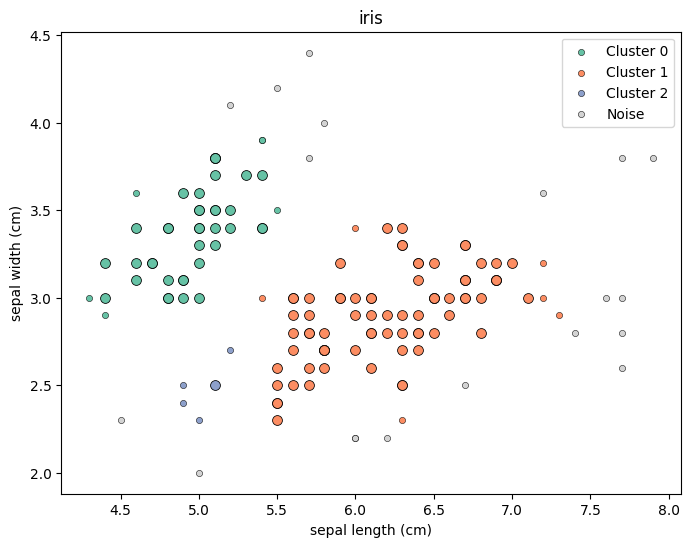


Dataset:  diabetes
Dataset shape:  (442, 2)
Execution Time: 0.0057985782623291016
Memory usage: 14.3
Eps: 0.014765 Min Samples: 6
Number of Core Points: 435
Number of Clusters: 2
Number of Unclassified Points: 2


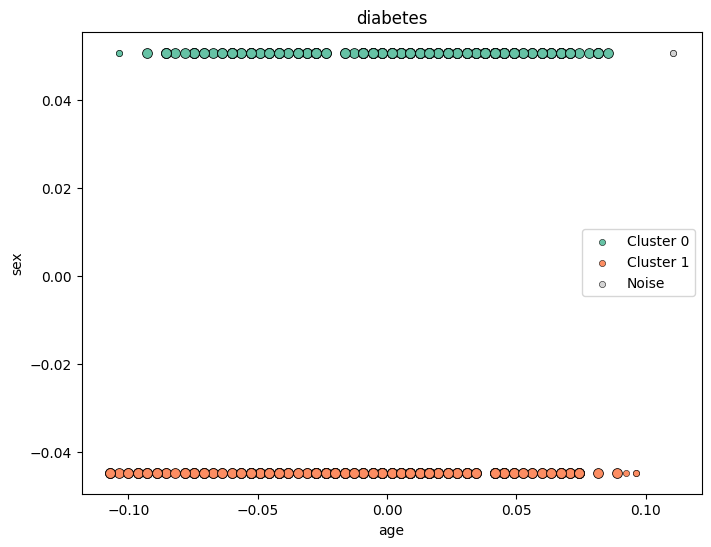


Dataset:  digits
Dataset shape:  (1797, 2)
Execution Time: 0.06848430633544922
Memory usage: 14.4
Eps: 1.038251 Min Samples: 7
Number of Core Points: 1795
Number of Clusters: 1
Number of Unclassified Points: 0


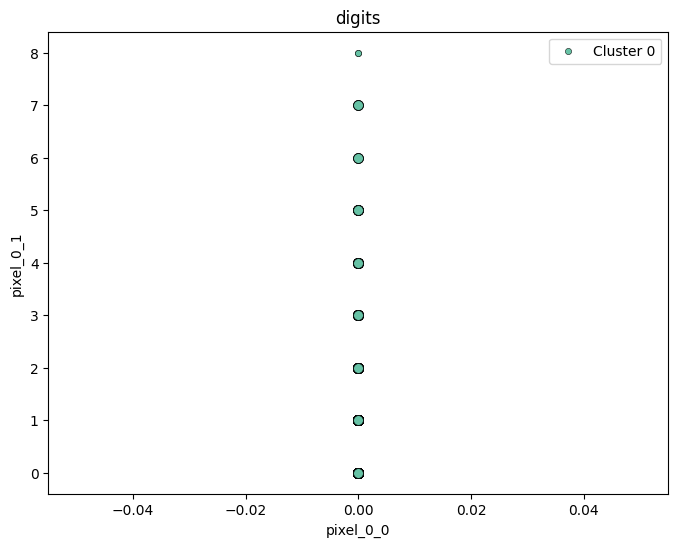


Dataset:  linnerud
Dataset shape:  (20, 2)
Execution Time: 0.0029141902923583984
Memory usage: 14.4
Eps: 41.911597 Min Samples: 2
Number of Core Points: 20
Number of Clusters: 1
Number of Unclassified Points: 0


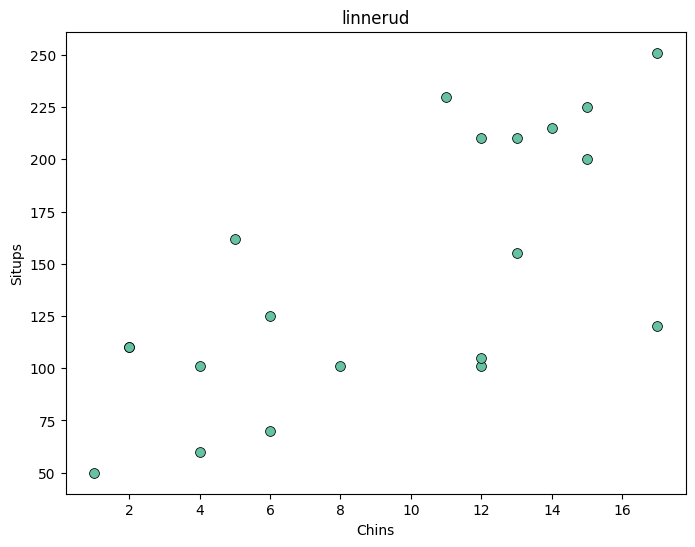


Dataset:  wine
Dataset shape:  (178, 2)
Execution Time: 0.014230966567993164
Memory usage: 14.4
Eps: 16.622963 Min Samples: 5
Number of Core Points: 178
Number of Clusters: 1
Number of Unclassified Points: 0


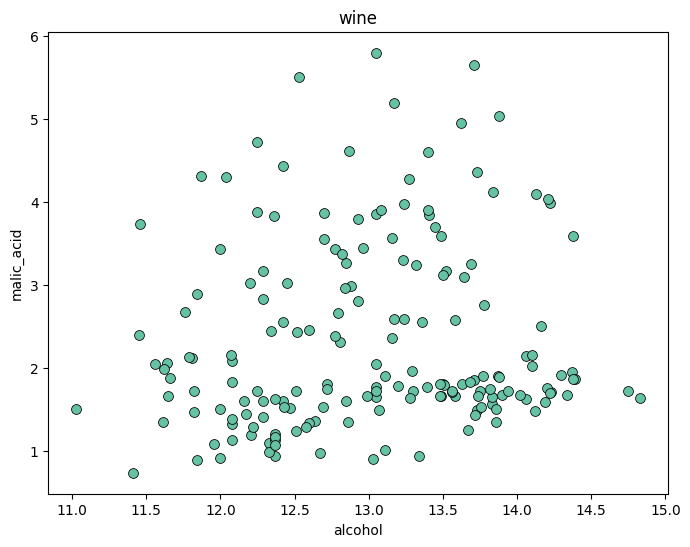


Dataset:  breast_cancer
Dataset shape:  (569, 2)
Execution Time: 0.01564812660217285
Memory usage: 14.4
Eps: 42.689478 Min Samples: 6
Number of Core Points: 569
Number of Clusters: 1
Number of Unclassified Points: 0


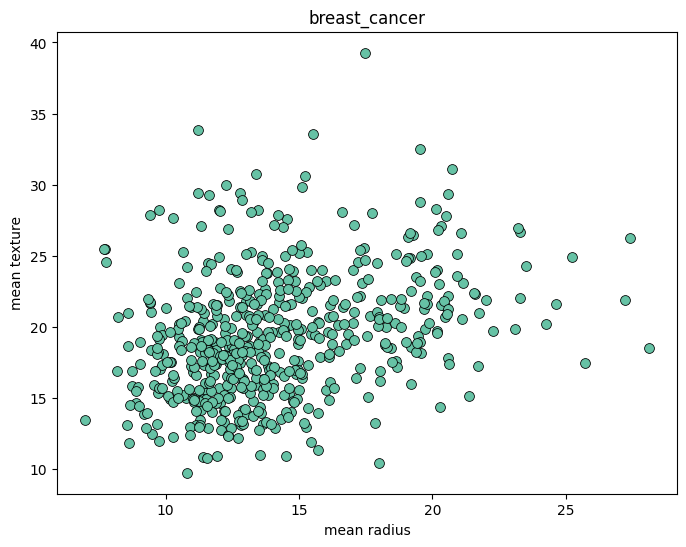


Resultados guardados en toy_datasets_solution.json


In [ ]:
# Declarar el diccionario con los conjuntos de datos de Toy Datasets y sus correspondientes valores de eps y num_samples
toy_datasets = {  'iris': {'dataset': datasets.load_iris(), 'eps': 0.25, 'min_samples': 5}, #0.199367
                      'diabetes': {'dataset': datasets.load_diabetes(), 'eps': 0.014765, 'min_samples': 6},
                      'digits': {'dataset': datasets.load_digits(), 'eps': 1.038251, 'min_samples': 7},
                      'linnerud': {'dataset': datasets.load_linnerud(), 'eps': 41.911597, 'min_samples': 2},
                      'wine': {'dataset': datasets.load_wine(), 'eps': 16.622963, 'min_samples': 5},
                      'breast_cancer': {'dataset': datasets.load_breast_cancer(), 'eps': 42.689478, 'min_samples': 6}
                    }

# Iterar por cada conjunto de datos de Toy Datasets
for dataset_name, _ in toy_datasets.items():
    # Obtener el conjunto de datos
    Y = toy_datasets[dataset_name]['dataset'].data
    x_1 = toy_datasets[dataset_name]['dataset'].feature_names[0]
    x_2 = toy_datasets[dataset_name]['dataset'].feature_names[1]

    # Reducir dimensión a dos entradas
    X_std = Y[:, :2]

    # Eliminar variables auxiliares pausadas para transformar el dataset
    del Y, toy_datasets[dataset_name]['dataset']
    gc.collect()

    # Obtener valores de eps y min_samples
    eps = toy_datasets[dataset_name]['eps']
    min_samples = toy_datasets[dataset_name]['min_samples']

    # Obtener timpo inicial
    start_time = time.time()

    # Ejecutar DBSCAN con los valores eps y min_samples correspondientes
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_std)

    # Obtener tiempo final y diferenica para obtener el tiempo de ejecución
    execution_time = time.time() - start_time

    # Obtener resultados
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    n_core_points = int(sum(core_samples_mask))
    n_noise = list(labels).count(-1)

    # Guardar resultados
    toy_datasets[dataset_name]['shape'] = X_std.shape
    toy_datasets[dataset_name]['clusters'] = n_clusters
    toy_datasets[dataset_name]['number_of_core_points'] = n_core_points
    toy_datasets[dataset_name]['noise'] = n_noise
    toy_datasets[dataset_name]['labels'] = labels.tolist()

    # Imprimir resultados
    print("\nDataset: ", dataset_name)
    print("Dataset shape: ", X_std.shape)
    print("Execution Time:", execution_time)
    print("Memory usage:", get_memory_usage_percentage())
    print("Eps:", eps, "Min Samples:", min_samples)
    print("Number of Core Points:", n_core_points)
    print("Number of Clusters:", n_clusters)
    print("Number of Unclassified Points:", n_noise)

    # Graficar clusters para visualización
    df = pd.DataFrame(X_std, columns=[x_1, x_2])
    plot_dbscan_results(df, labels, core_samples_mask, dataset_name)

# Guardar resultados de DBSCAN en un archivo JSON para usarlos como referencia en el análisis posterior
file_name = 'toy_datasets_solution.json'
with open(file_name, 'w') as file:
    json.dump(toy_datasets, file, indent=4)
    print(f"\nResultados guardados en {file_name}")


Dataset:  Iris
Dataset shape:  (150, 2)
Execution Time: 0.01564812660217285
Memory usage: 13.9
Eps: 0.199367 Min Samples: 5
Number of Core Points: 81
Number of Clusters: 3
Number of Unclassified Points: 51


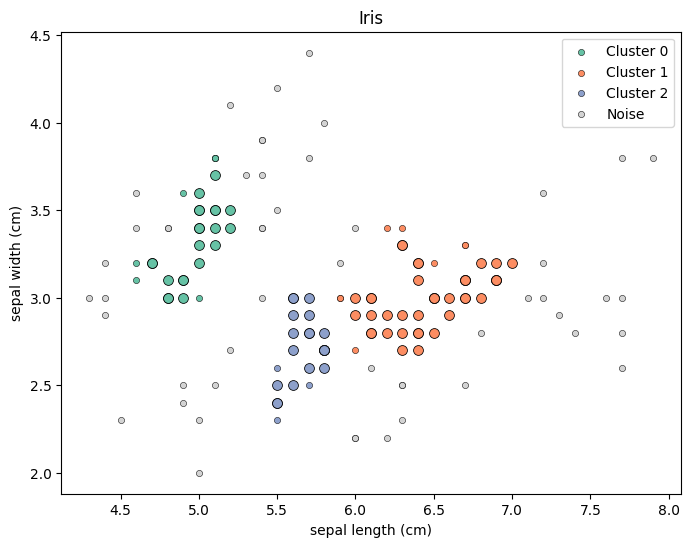

In [ ]:
# Declarar el diccionario con los conjuntos de datos de Toy Datasets y sus correspondientes valores de eps y num_samples
toy_datasets = {  'dataset': datasets.load_iris(), 'eps': 0.199367, 'min_samples': 5}
dataset_name = 'Iris'

Y = toy_datasets['dataset'].data
x_1 = toy_datasets['dataset'].feature_names[0]
x_2 = toy_datasets['dataset'].feature_names[1]

Y = Y[:, :2]

# Reducir dimensión a dos entradas
pca = PCA(n_components=2)
X_std = pca.fit_transform(Y)


# Obtener valores de eps y min_samples
eps = toy_datasets['eps']
min_samples = toy_datasets['min_samples']


db = DBSCAN(eps=eps, min_samples=min_samples).fit(Y)


# Obtener resultados
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
n_core_points = int(sum(core_samples_mask))
n_noise = list(labels).count(-1)



# Imprimir resultados
print("\nDataset: ", dataset_name)
print("Dataset shape: ", Y.shape)
print("Execution Time:", execution_time)
print("Memory usage:", get_memory_usage_percentage())
print("Eps:", eps, "Min Samples:", min_samples)
print("Number of Core Points:", n_core_points)
print("Number of Clusters:", n_clusters)
print("Number of Unclassified Points:", n_noise)

# Graficar clusters para visualización
df = pd.DataFrame(Y, columns=[x_1, x_2])
plot_dbscan_results(df, labels, core_samples_mask, dataset_name)


In [ ]:
datasets.load_iris()

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

## Procesamiento de imágenes

Si bien el algoritmo de DBSCAN suele utilizarse, principalmente, para el análisis de datos de forma tradicional, también se puede utilizar para detectar agrupamientos (clusters) y ruido (outliers) en imágenes. Esto es posible debido a que una imagen es un mapa de bits y, de esta forma, se puede interpretar el mapa de bits como una matriz que contiene los colores del pixel como valor de cada posición.

Así pues, al considerar la posición y los colores como parte de la dimensión del conjunto de datos, se pueden detectar agrupamientos y ruido en imágenes, de tal forma que el algoritmo de DBSCAN forma parte del procesamiento de imágenes.

Estas imaágenes procesadas pueden ser un resultado final en sí o pueden formar parte de un flujo (pipeline) de procesamiento y detección de imágenes más complejo.

### Mastografía




Un gran ejemplo de la utilidad de DBSCAN en el procesamiento de imágenes es la detección de anomalías en radiografías y tomografías. En el presente ejemplo, se obtuvo una imagen de una [mastografía con un nódulo cancerígeno](https://www.pbs.org/wgbh/nova/article/breast-microbiome-profiles-linked-to-higher-or-lower-chance-of-cancer/). Al aplicar el algoritmo DBSCAN a la imagen considerando la posición de cada pixel (x,y) así como el color (R,G,B) como las características de cada valor de la matriz de datos, se pueden obtener los cluster y outliers de la imagen, de tal forma que es más sencillo identifcar los cúmulos de células que destacan.

Es importante destacar que esta aproximación es una herramienta para poder identificar anomalías, pero no es concluyente para un diagnóstico.

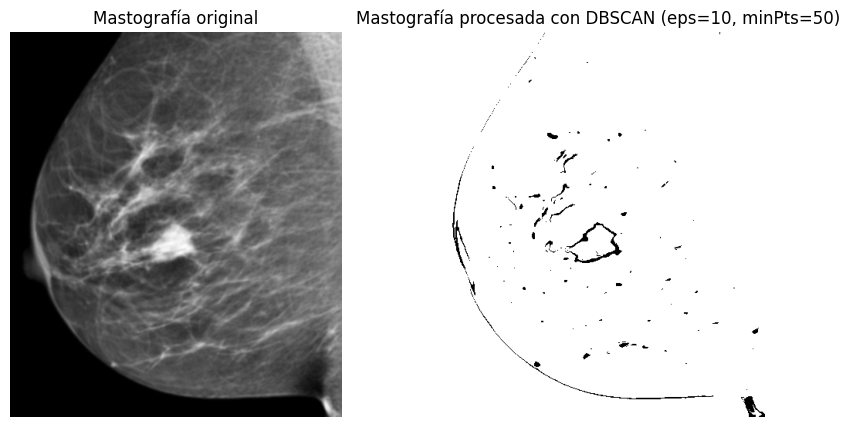

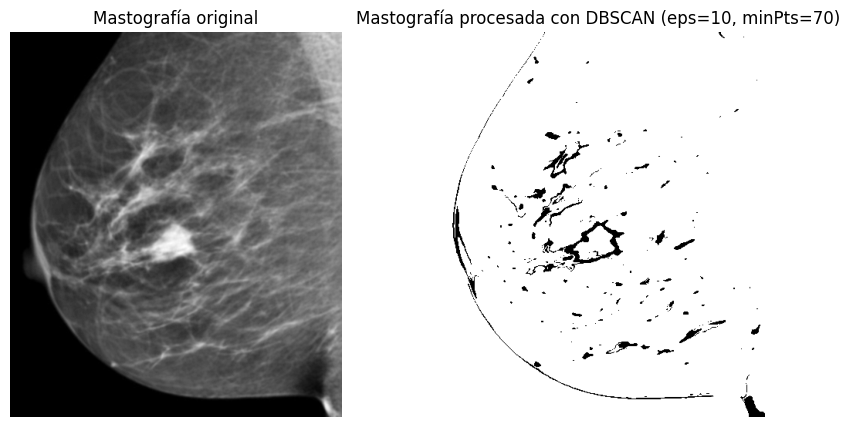

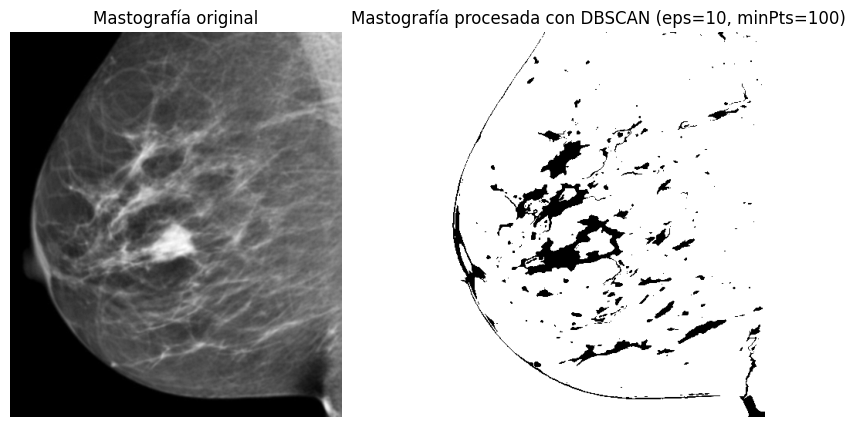

In [ ]:
# Cargar imagen
image_path = 'breast_cancer_mammogram.jpg'  # Adjusted path to the uploaded file
image = Image.open(image_path).convert('L')  # Convert image to grayscale
image = image.filter(ImageFilter.GaussianBlur(radius=1))  # Apply Gaussian Blur

pixels = np.array(image)

# Preparar la matriz de caractarísticas con 5 dimensiones: [R, G, B, X, Y]
height, width = pixels.shape
X, Y = np.meshgrid(range(width), range(height))
features = np.stack((pixels.ravel(), X.ravel(), Y.ravel()), axis=1)

# Experimentar con distintos parámetros de DBSCAN
eps_values = [10]
min_samples_values = [50, 70, 100]

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(features)

        # Visualizar los los resultados del clustering para cada combinación de parámetros
        unique_clusters = np.unique(clusters)
        output_image = np.zeros((height, width), dtype=np.uint8)

        for cluster in unique_clusters:
            if cluster == -1:  # Outliers
                color = 0  # Color negro
            else:
                color = 255  # Color blanco o cualquier otro

            output_image[clusters.reshape(height, width) == cluster] = color

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap='gray')
        plt.title('Mastografía original')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(output_image, cmap='gray')
        plt.title(f'Mastografía procesada con DBSCAN (eps={eps}, minPts={min_samples})')
        plt.axis('off')

        plt.show()

### Detección de barcos


Otro gran ejemplo de la utilidad de DBSCAN en el procesamiento de imágenes es la detección de barcos en el mar, ya sea para rescate o para detección de enemigos. Esta misma intuición puede ser usada para detectar aeronaves o automóviles terrestres. Para esta ejemplificación se obtuvo la imagen del sistio del [Sistema de seguridad y monitoreo marítimo de Brics](https://newsilkroadbrics.com/ready-for-the-northern-sea-route/)

Al igual que en el caso anterior, se consideran las posiciones (x,y) y los colores (R,G,B) de cada pixel como las características del conjunto de datos.

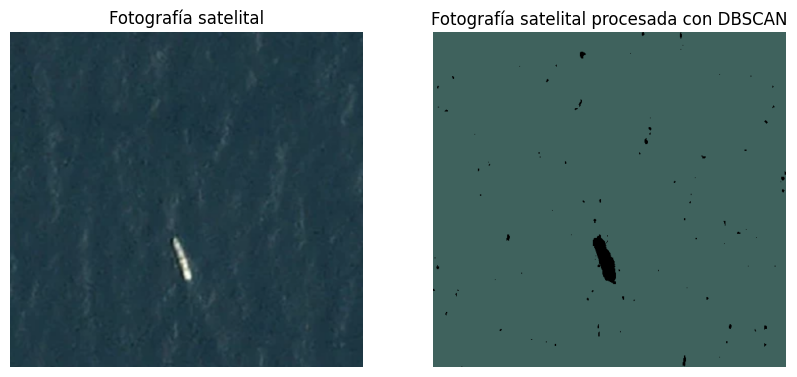

In [ ]:
# Cargar imagen
image_path = 'navy_vessel.png'  # Make sure this path is correct
image = Image.open(image_path).convert('RGB')  # Convert image to RGB
pixels = np.array(image)

# Preparar la matriz de caractarísticas con 5 dimensiones: [R, G, B, X, Y]
height, width = pixels.shape[:2]  # Only take height and width
X, Y = np.meshgrid(range(width), range(height))
features = np.concatenate((pixels.reshape(-1, 3), X.reshape(-1, 1), Y.reshape(-1, 1)), axis=1)

# Estandarizar los valores de las características para un mejor desempeño
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=50)
clusters = dbscan.fit_predict(features_scaled)

# Visualizar resultados
unique_clusters = np.unique(clusters)
output_image = np.zeros((height, width, 3), dtype=np.uint8)
for cluster in unique_clusters:
    if cluster == -1:  # Outliers
        color = [0, 0, 0]  # Black
    else:
        color = np.random.randint(0, 255, size=3)
    output_image[clusters.reshape(height, width) == cluster] = color

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Fotografía satelital')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output_image)
plt.title('Fotografía satelital procesada con DBSCAN')
plt.axis('off')

plt.show()

## Ventaja de DBSCAN sobre otros algoritmos de agrupamiento (clustering)

### Comparación de diferentes algoritmos de agrupamiento (clustering)



Este [ejemplo](https://scikit-learn.org/0.15/auto_examples/cluster/plot_cluster_comparison.html) tiene como objetivo mostrar las características de diferentes algoritmos de agrupamiento (clustering) en conjuntos de datos que son "interesantes" pero aún en 2D. El último conjunto de datos es un ejemplo de una situación 'nula' para el agrupamiento: los datos son homogéneos y no hay un buen agrupamiento.

Mientras que estos ejemplos dan cierta intuición sobre los algoritmos, esta intuición podría no aplicarse a datos de muy alta dimensionalidad.

Los resultados podrían mejorarse ajustando los parámetros para cada estrategia de agrupamiento, por ejemplo, estableciendo el número de grupos para los métodos que necesitan este parámetro especificado. Note que la propagación de afinidad tiene tendencia a crear muchos grupos. Por lo tanto, en este ejemplo, sus dos parámetros (amortiguamiento y preferencia por punto) se establecieron para mitigar este comportamiento.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:282: UserWarning: the number of connected components of the c

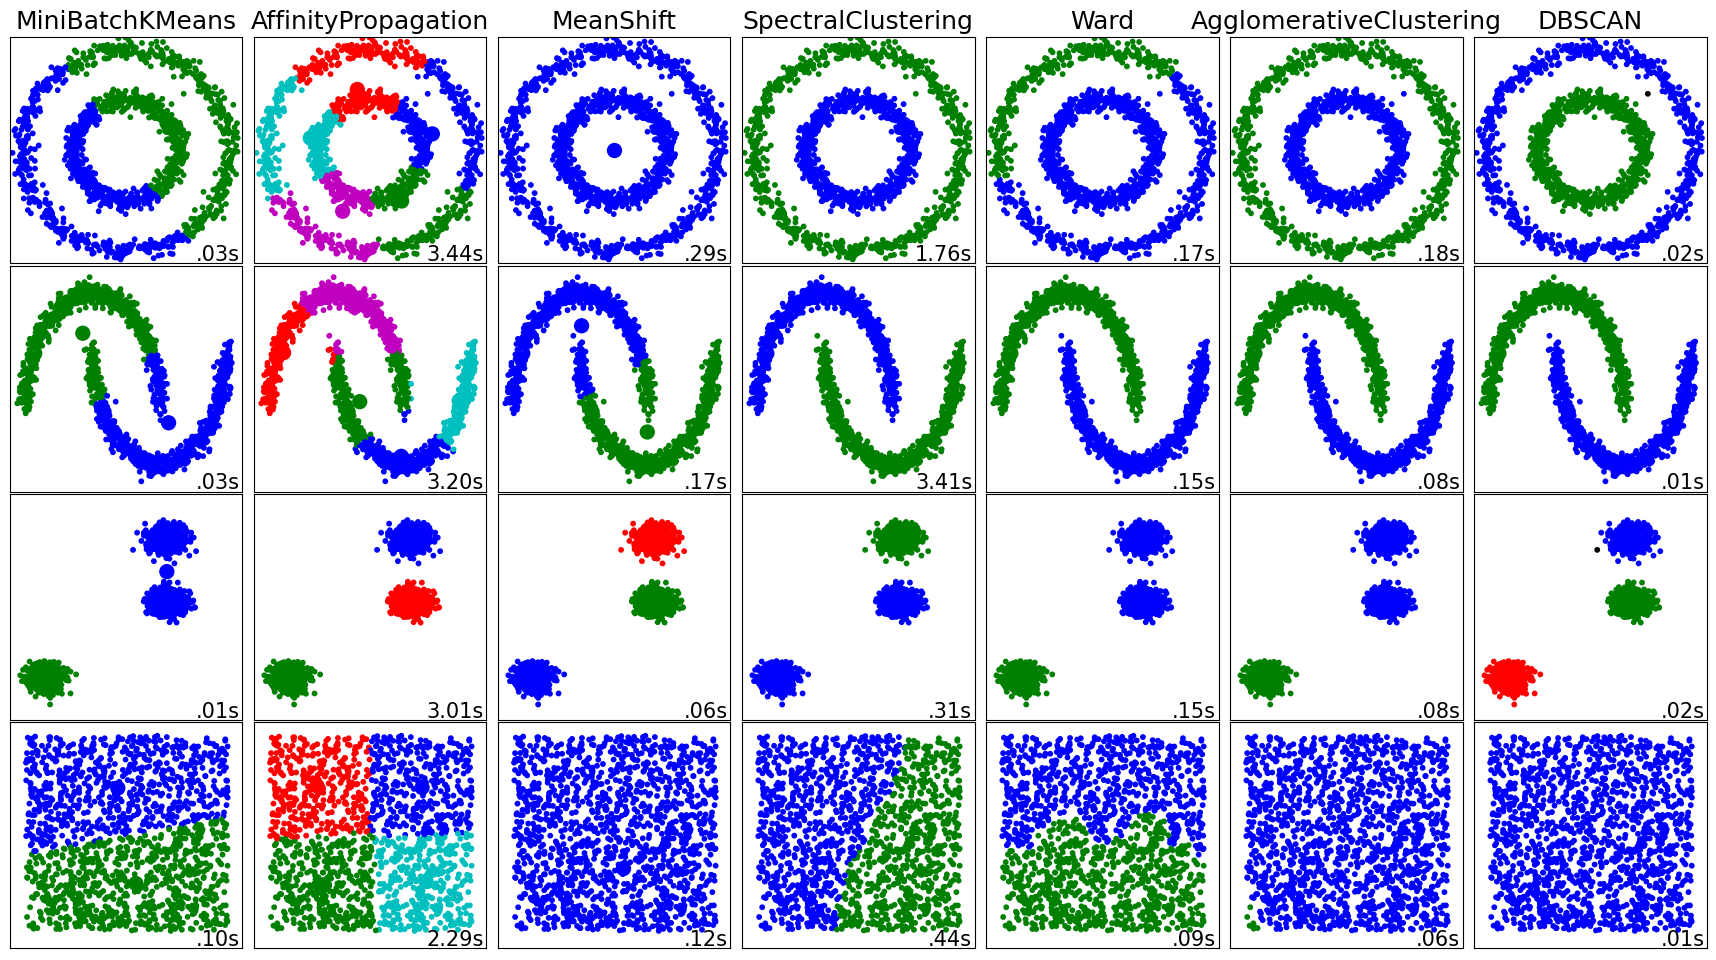

In [ ]:
np.random.seed(0)

# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

plt.figure(figsize=(17, 9.5))
plt.subplots_adjust(left=.001, right=.999, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1
for i_dataset, dataset in enumerate([noisy_circles, noisy_moons, blobs,
                                     no_structure]):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=10)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # Compute distances
    #distances = np.exp(-euclidean_distances(X))
    distances = euclidean_distances(X)

    # create clustering estimators
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=2)
    ward = cluster.AgglomerativeClustering(n_clusters=2,
                    linkage='ward', connectivity=connectivity)
    spectral = cluster.SpectralClustering(n_clusters=2,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=.2)
    affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                       preference=-200)

    average_linkage = cluster.AgglomerativeClustering(linkage="average",
                            affinity="cityblock", n_clusters=2,
                            connectivity=connectivity)

    for name, algorithm in [
                            ('MiniBatchKMeans', two_means),
                            ('AffinityPropagation', affinity_propagation),
                            ('MeanShift', ms),
                            ('SpectralClustering', spectral),
                            ('Ward', ward),
                            ('AgglomerativeClustering', average_linkage),
                            ('DBSCAN', dbscan)
                           ]:
        # predict cluster memberships
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)

        else:
            y_pred = algorithm.predict(X)

        # plot
        plt.subplot(4, 7, plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

La gráfica muestra una comparativa visual de diferentes algoritmos de clustering aplicados a varios conjuntos de datos 2D. Cada fila representa un tipo de distribución de datos distinta y cada columna corresponde a un algoritmo de clustering diferente. Se observa que algunos algoritmos funcionan mejor con ciertos tipos de distribuciones de datos.

**Conclusiones generales:**
1. **Adaptabilidad**: Algunos algoritmos, como DBSCAN y Agglomerative Clustering, se adaptan bien a una variedad de formas de datos, mientras que otros, como MiniBatchKMeans, funcionan mejor con distribuciones de datos esféricas o globulares.
2. **Número de Clústeres**: Métodos como Affinity Propagation y DBSCAN no requieren un número predefinido de clústeres, lo que puede ser útil en situaciones donde este número no es conocido de antemano.
3. **Tiempo de Ejecución**: En la esquina inferior derecha de cada gráfico, se muestra el tiempo de ejecución del algoritmo. Algoritmos como MiniBatchKMeans son rápidos, mientras que Affinity Propagation es considerablemente más lento.
4. **Sensibilidad al Ruido**: Algunos algoritmos, como DBSCAN, están diseñados para manejar el ruido en los datos, lo que los hace útiles para aplicaciones del mundo real donde los datos pueden estar sucios o ser imperfectos.

**Conclusiones específicas para DBSCAN:**
1. **Resistencia a la Forma**: DBSCAN puede identificar clústeres de formas irregulares, como se ve en la fila del medio, donde los algoritmos basados en centroides fallan.
2. **Puntos de Ruido**: DBSCAN puede diferenciar el ruido, mostrado en rojo, de los puntos que pertenecen a un clúster. Esto es particularmente útil en datos con puntos aislados.
3. **Densidad**: Este algoritmo depende de la densidad para formar clústeres, lo que puede ser una limitación en datos con variaciones significativas de densidad, pero una ventaja en datos bien definidos y consistentes en densidad.
4. **Consistencia**: DBSCAN proporciona resultados consistentes a través de los diferentes tipos de conjuntos de datos, lo que demuestra su robustez en diversas situaciones de clustering.
5. **Parametrización**: La eficacia de DBSCAN depende fuertemente de la elección de sus parámetros (eps y min_samples), como se puede deducir al observar el rendimiento variado en diferentes conjuntos de datos. La elección correcta de estos parámetros es crucial para obtener un buen rendimiento.

### Ventaja de DBSCAN sobre K-Means

#### Conjunto de datos Cráter



A continuación, se trabaja con un conjunto de datos sintéticos llamado [Cráter](https://domino.ai/blog/topology-and-density-based-clustering#body__be5a25463ec4) que representa un caso desfavorable para el algoritmo de `k-means`. Este conjunto de datos es conocido como $cráter$ debido a su forma. Los puntos de datos están almacenados en un archivo llamado `crater.csv`.




Dimensiones del DataFrame:  (1500, 3)


,x_1,x_2,kmeans_label
0,-1.719159,-2.500154,1
1,-3.002477,-4.801853,1
2,0.469441,1.591334,0


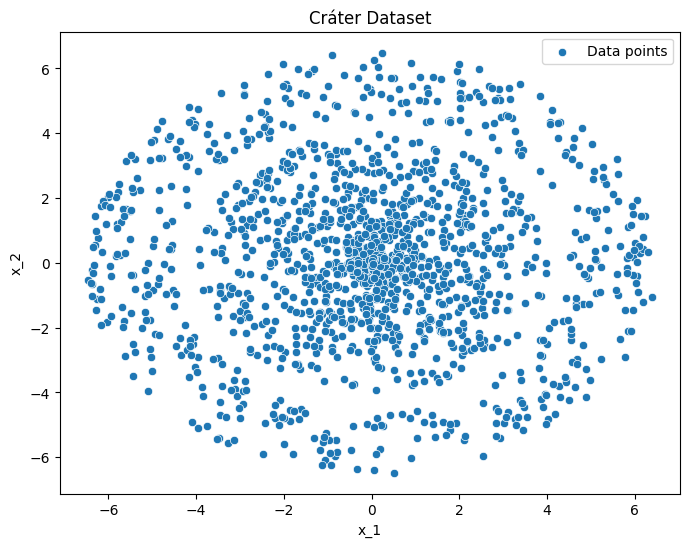

In [ ]:
crater = pd.read_csv('./crater.csv')
print("Dimensiones del DataFrame: ", crater.shape)
display(crater.head (3))
plot_df_2d(crater, "Cráter Dataset")

#### Cráter con K-Means


Las etiquetas de los clusters obtenidas por el algoritmo K-means ya están procesadas con anticipación y ya son parte del DataFrame, razón por la cual no se computa dicho algoritmo en el presente código.

A continuación, se grafica la clasificación de clusters propia de K-means para este conjunto de datos llamado Cráter.

Como se puede observar, se identifican, de forma extraña y errónea, dos clusters, uno arriba y otoro abajo. Sin embargo, a simple vista, se puede detectar que hay un agrupamiento denso de puntos en el centro y otro alrededor formando una especie de dona.

Este caso o contraejemplo, muestra una deficiencia evidente del algoritmo K-means. Esto sucede debido a su lógica algorítmica donde los centroides pueden quedar en un centro de densidad que no es el adecuado.

Además de este posible error, hay otras deficiencias de este algoritmo de clusterizado respecto a DBSCAN como por ejemplo: se tiene que determinar el número de clusters de antemano y no detecta outliers.

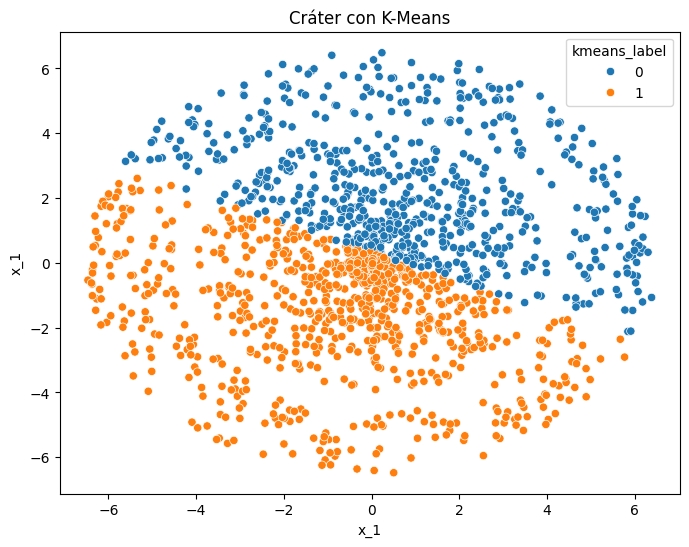

In [ ]:
make_scatter_plot(crater, "Cráter con K-Means", hue='kmeans_label')

#### Cráter con DBSCAN



Como podemos ver, a continuación, el algoritmo DBSCAN reconoce de mejor forma los clusters del conjunto de datos llamado Cráter, además, no es necesario especificar la cantidad de clusters de antemano. Sin embargo, sí es necesario especificar la distancia `eps` que determina la proximidad de los puntos para ser consideraods vecinos y  `num_samples` la cantidad de vecinos necesarios para poder considerar a un punto como núcleo.

El algoritmo DBSCAN adopta un enfoque diferente. En lugar de tener que proporcionar el número de clusters,  k , se definen parámetros relacionados con vecindarios y densidad objetivo. Este método identifica clusters basándose en la densidad de los puntos de datos, lo que le permite descubrir grupos de formas variadas y tamaños. Se definen dos parámetros principales: el radio  ϵ  (epsilon), que determina el tamaño del vecindario alrededor de cada punto, y el número mínimo de puntos,  minPts , necesario para formar un cluster. Un punto se considera central si dentro de su vecindario de radio  ϵ  hay al menos  minPts . Esto permite al DBSCAN ser más flexible en la identificación de clusters comparado con k-means, especialmente en presencia de datos con formas irregulares o cuando hay ruido en el dataset.

Cantidad de clusters: 13
Cantidad de outliers: 394


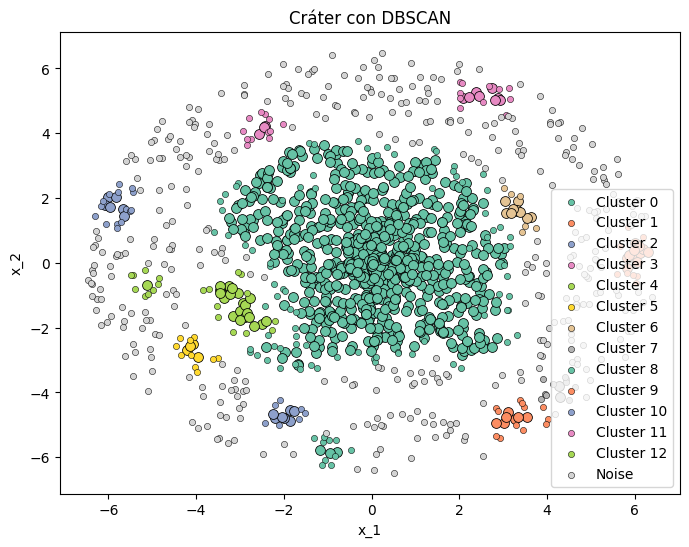

In [ ]:
# Quitar los valores de las etiquetas de k-means del conjunto de datos
if 'kmeans_label' in crater.columns:
    crater = crater.drop('kmeans_label', axis=1)
X = crater.to_numpy()

# Computar DBSCAN
db = DBSCAN(eps=0.5, min_samples=10).fit(X)

# Obtener las etiquetas de los clusters
labels = db.labels_

# Obtener el número de clusters y de outliers
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Obtener el nñumero de core samples
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
n_core_points = sum(core_samples_mask)

# Imprimir resultados
print("Cantidad de clusters: %d" % n_clusters_)
print("Cantidad de outliers: %d" % n_noise_)

# Graficar resultados
df = pd.DataFrame(X, columns=['x_1', 'x_2'])
plot_dbscan_results(df, labels, core_samples_mask, "Cráter con DBSCAN")

Cantidad de clusters: 10
Cantidad de outliers: 31


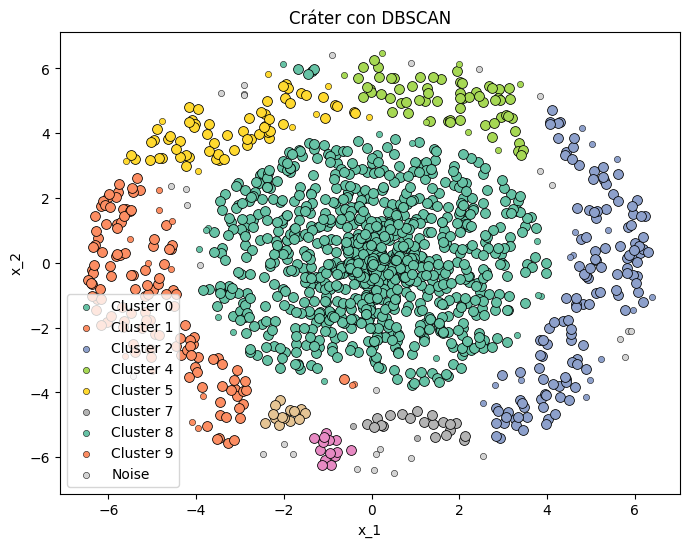

In [ ]:
# Quitar los valores de las etiquetas de k-means del conjunto de datos
if 'kmeans_label' in crater.columns:
    crater = crater.drop('kmeans_label', axis=1)
X = crater.to_numpy()

# Computar DBSCAN
db = DBSCAN(eps=0.5, min_samples=4).fit(X)

# Obtener las etiquetas de los clusters
labels = db.labels_

# Obtener el número de clusters y de outliers
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Obtener el nñumero de core samples
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
n_core_points = sum(core_samples_mask)

# Imprimir resultados
print("Cantidad de clusters: %d" % n_clusters_)
print("Cantidad de outliers: %d" % n_noise_)

# Graficar resultados
df = pd.DataFrame(X, columns=['x_1', 'x_2'])
plot_dbscan_results(df, labels, core_samples_mask, "Cráter con DBSCAN")